In [1]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# loading two images 
image_left= cv2.imread("assignment_7/assgImg_1.png") #left
image_right= cv2.imread("assignment_7/assgImg_2.png") #right

# setting pixels 
r_w = 500
r_h = 500

# resizing the images using opencv resize function
image_left = cv2.resize(image_left,(r_w,r_h),interpolation = cv2.INTER_AREA)
image_right = cv2.resize(image_right,(r_w,r_h),interpolation = cv2.INTER_AREA)

# Converting image to grayscale
gray_image_left = cv2.cvtColor(image_left ,cv2.COLOR_BGR2GRAY)
gray_image_right = cv2.cvtColor(image_right,cv2.COLOR_BGR2GRAY)

cv2.imwrite('before_panoram_original_images.jpg',np.hstack((image_left,image_right)))
#cv2.waitKey(0)

True

In [3]:
#function to detect keypoints and describe them as feature vectors

def keypoints_features(gray_image):
    #create an instance of the object detector and descriptor
    descriptor = cv2.SIFT_create()
    (kpts,features)=descriptor.detectAndCompute(gray_image,None) #detect and extract the features from images
    
    KeyPts = []
    
    for pts in kpts:
        pt = np.float32(pts.pt) #converting keypoints from keypoints object to numpy array
        KeyPts.append(pt)
    
    return (KeyPts,features) #return the keypoints and features

In [4]:
(kpts_1,features_1)=keypoints_features(gray_image_right) # calling keypoint_fetaures function
(kpts_2,features_2)=keypoints_features(gray_image_left) # detect and extract the features from images
print(features_1)

[[ 0.  0.  0. ...  6.  7. 44.]
 [ 3. 11.  5. ...  0.  0.  1.]
 [ 0.  0.  4. ...  0.  0.  0.]
 ...
 [ 0.  0. 11. ... 24. 55. 10.]
 [ 0.  0.  0. ... 12. 40.  7.]
 [12.  8. 58. ... 35. 23. 12.]]


### Creating matching points function (step 2 & step 3)

In [28]:
def match_pts(KeyPts_1,KeyPts_2,features_1,features_2,ratio=0.75,thresh=4.0):#0.75,4.0
    match_method = cv2.DescriptorMatcher_create("BruteForce") #creating Brute force matcher object
    
    '''using K nearest neighbor method to match the features.
       the number of nearest neighbor is set to 2'''
    
    nearest_neighbor = 2
    rawmatches = match_method.knnMatch(features_1,features_2,nearest_neighbor)  #match descriptors(features)
    matches = []
    
    # ratio test to retain only the good matche
    #loop over the rawmatches
    for match in rawmatches:
        '''checking the distance of the two matches with the ratio under consideration'''
        if len(match)==2 and match[0].distance < match[1].distance * ratio:
            matches.append((match[0].trainIdx,match[0].queryIdx))
            
    
    #A minimum of four matches is required to calculate the homography_matrix
    #the matrix contains the information to warp the images
    
    if len(matches) > 4:
        pts_image1 = [] # constructing the two sets of points
        pts_image2 = []
        '''converting the keypoints to numpy arrays before passing them for calculating Homography Matrix.
        Because we are supposed to pass 2 arrays of coordinates to cv2.findHomography, as in I have these points in image1,
        and I have points in image-2, so now what is the homography matrix to transform the points from image 1 to image 2'''
        
        for _,index in matches:
            pts = np.float32(KeyPts_1[index])
            pts = KeyPts_1[index]
            pts_image1.append(pts)
            
        for index,_ in matches:
            pts = np.float32(KeyPts_2[index])
            pts = KeyPts_2[index]
            pts_image2.append(pts)
            
        pts_image1 = np.array(pts_image1,dtype = np.float32)
        pts_image2 = np.array(pts_image2,dtype = np.float32)

        #computing the homography btween the two sets of points
        (Homography_matrix,status)=cv2.findHomography(pts_image1,pts_image2,cv2.RANSAC,thresh)
        
        return (matches,Homography_matrix,status)  #return the matches along with homography matrix status of each matched pair
   
    return None  #return none ,when no homography computed
 

In [29]:
M = match_pts(kpts_1,kpts_2,features_1,features_2) # matching features between two images using match_pts function

#if match is none,then there aren’t enough matched keypoints to create a panorama
if M is None:
    point("No matches found")
    exit()
    
(matches,Homography_matrix,status) = M

In [30]:
print('Homography_matrix',Homography_matrix)

Homography_matrix [[ 8.36627475e-01 -1.08449738e-02  3.23045906e+02]
 [-6.17305703e-02  9.69205885e-01  1.63527078e+01]
 [-3.15696460e-04  3.14758250e-06  1.00000000e+00]]


'''Explaination 

1. As we can see match_pts functions takes four arguments:keyPts_1,features_1 associated with image_1 and
   keyPts_2,features_2 associated with image_2,ratio and threshold.
  
2. Matching features together is actually a fairly straightforward process.We simply loop over the descriptors 
   from both images,compute the distances,and find the smallest distance for each pair of descriptors.
  
3. For the above task,OpenCV has a built-in function called cv2.DescriptorMatcher_create that constructs the feature matcher.

4. The BruteForce value indicates that we are going to exhaustively compute the Euclidean distance between all feature vectors 
   from both images and find the pairs of descriptors that have the smallest distance.
   
#feature matching

5. rawmatches = match_method.knnMatch(features_1,features_2,nearest_neighbor),in this knn-match performs the K-NN matching 
   between the two feature vector sets using k=2(indicating the top two matches for each feature vector are returned). 


6. the reason we want the top two matches rather than just the top one match is because we need to apply David Lowe’s ratio test 
   for false-positive match pruning.
  
7. Actually in line 5 we have computed the rawMatches for each pair of descriptors — but there is a chance that some of 
   these pairs are false positives,meaning that the image patches are not actually true matches.
  
8. In an attempt to prune these false-positive matches, we can loop over each of the rawMatches individually
   and apply Lowe’s ratio test, which is used to determine high-quality feature matches. 
   Typical values for Lowe’s ratio are normally in the range [0.7, 0.8].
   
9. Basically in lowe's test, when we match the keypoints,we reject the matches in which the ratio of the distances to the
   nearest neighbor and the second nearest neighbor is greater than a certain threshold. 
   This helps us in discarding the points that are not distinct enough. 
   So, we use that concept here to keep only the good matches and discard the rest.
   
#Homography calculation 

9. To Compute a homography between two sets of points requires minimum of four matches.if less matches are found,
   there will no homograpy computed and it will returns to None.

   
10. findHomography method uses RANSAC alogorithm which produces right matches(inliers)even in presence of large number
    of bad matches(outliers).

'''


### Creating Visualize_matches function

In [31]:
def visualize_matches(image_1,image_2,KeyPts_1,KeyPts_2,matches,status):
    #initialize the output visualization image
    (h_1,w_1)=image_1.shape[0],image_1.shape[1]
    (h_2,w_2)=image_2.shape[0],image_2.shape[1]
    stacked_image = np.zeros((max(h_1,h_2),w_1 + w_2,3),dtype="uint8") # create output image that concatenate two images together
    stacked_image[0:h_1,0:w_1] = image_1
    stacked_image[0:h_2,w_1:] = image_2
    
    #loop over the matches
    for ((trainIdx,queryIdx),stat) in zip(matches,status):
        #only process the match if the keypoint was successfully matched
        if stat == 1:
            
            #draw the match
            pt_1 = (int(KeyPts_1[queryIdx][0]),int(KeyPts_1[queryIdx][1]))
            pt_2 = (int(KeyPts_2[trainIdx][0]) + w_1,int(KeyPts_2[trainIdx][1]))
            cv2.line(stacked_image,pt_1,pt_2,(0,255,0),1)              # this function draw line to connect pt_1 & pt_2
         
            #return the visualization
    return stacked_image


In [32]:
keypts_matchimage = visualize_matches(image_right,image_left,kpts_1,kpts_2,matches[:],status) # calling visualize function

In [33]:
cv2.imwrite("key_points_match_image.jpg",keypts_matchimage)
#cv2.imshow("key points match",keypts_matchimage)
#cv2.waitKey(0)

True


'''Explaination

visualize_matches function takes six arguments: 

1.two original images,

2.the set of keypoints associated with each image,

3.the initial matches after applying Lowe’s ratio test, 

4.and finally the status list provided by the homography calculation.

5.In the second line of this function, we are defining the row and the column of the first and the second image. 
  Then, we create a black image using the function np.zeros()
  
6.This image will have the same dimensions as the output image where two input images are stitched together.

7.That is why we will set the number of rows to the larger of the two values, and the number of columns will be 
  the sum of both values.

8.The next step is to create for loop which will iterate through all matches.

9.using these variables, we can visualize the “inlier” keypoints by drawing a straight line from keypoint pt_1 in the 
  first image to keypoint pt_2 in the second image.'''

## Stitch images together

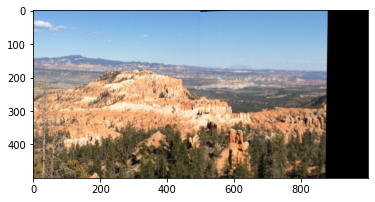

In [34]:
#applying a perspective warp to stitch the images together(step4)

stitched_image = cv2.warpPerspective(image_right,Homography_matrix,(image_right.shape[1] + image_left.shape[1],
                                                                    max(image_right.shape[0],image_left.shape[0])))
stitched_image[0:image_left.shape[0],0:image_left.shape[1]]=image_left

cv2.imwrite('stitched_image.jpg',stitched_image)
plt.imshow(cv2.cvtColor(stitched_image ,cv2.COLOR_BGR2RGB))
#cv2.waitKey(0)

'''Explaination

1.We can apply our transformation by calling the cv2.warpPerspective function. 

2.The first parameter is our original image that we want to warp,the second is our transformation matrix M 
(which will be obtained from step3), and the final parameter is a tuple, 
 used to indicate the width and height of the output image.

3.For the calculation of the width and height of the final horizontal panoramic images,just add the widths of 
  the individual images and for the height take the max from the 2 individual images.
  
4.we can see stitched image(panorama view) output images.'''

### Creating triming function

In [13]:
# we can see there is dark side ,we are going to trim this part for better panorama view 

def trim(frame):
    #crop top
    if not np.sum(frame[0]):
        return trim(frame[1:])
    #crop bottom
    elif not np.sum(frame[-1]):
        return trim(frame[:-2])
    #crop left
    elif not np.sum(frame[:,0]):
        return trim(frame[:,1:]) 
    #crop right
    elif not np.sum(frame[:,-1]):
        return trim(frame[:,:-2])    
    return frame

In [14]:
Panorama_image = trim(stitched_image)
cv2.imwrite('Panorama_image.jpg',Panorama_image)
#cv2.imshow('Panorama_image',Panorama_image)
#cv2.waitKey(0)

True

In [15]:
# comparision of seperate images(image_left,image_right) and stitched image

cv2.imwrite('original(left,right) vs panorama.jpg',np.hstack((image_left,image_right,Panorama_image)))


True